In [1]:
import tensorflow as tf
from tensorflow import keras

In [47]:
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

In [3]:
import gym

In [4]:
env = gym.make('CartPole-v1')

In [5]:
env.seed(42)
obs = env.reset()

In [6]:
obs

array([-0.01258566, -0.00156614,  0.04207708, -0.00180545])

In [7]:
env.render()

True

In [8]:
img = env.render(mode="rgb_array")
img.shape

(400, 600, 3)

In [17]:

def plot_environment(env, figsize=(5,4)):
    plt.figure(figsize=figsize)
    img = env.render(mode="rgb_array")
    plt.imshow(img)
    plt.axis("off")
    return img

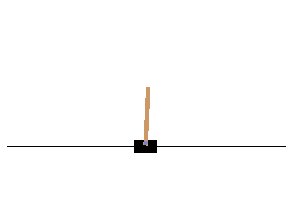

In [10]:
plot_environment(env)
plt.show()

In [11]:
env.action_space

Discrete(2)

In [35]:
action = 1  # accelerate right
obs, reward, done, info = env.step(action)
obs

array([ 0.06894397,  1.36267407, -0.07668337, -2.01836552])

In [36]:
reward

1.0

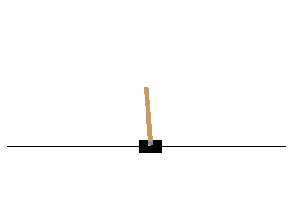

In [37]:
plot_environment(env)
plt.show()

In [38]:
obs[2]

-0.07668337299143604

# Basic hard-coded policy

In [39]:
# If the mast leans towards left accelerate left, else accelerate right

def basic_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1


In [40]:
totals = []
for episode in range(500):
    episode_rewards = 0
    obs = env.reset()
    for step in range(200):
        action = basic_policy(obs)
        obs, reward, done, info = env.step(action)
        episode_rewards += reward
        if done:
            break
    totals.append(episode_rewards)

In [41]:
np.mean(totals), np.std(totals), np.min(totals), np.max(totals)

(41.684, 8.839917646675222, 24.0, 68.0)

Let's visualise one episode

In [42]:

env.seed(42)

frames = []

obs = env.reset()
for step in range(200):
    img = env.render(mode="rgb_array")
    frames.append(img)
    action = basic_policy(obs)

    obs, reward, done, info = env.step(action)
    if done:
        break


In [48]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

In [49]:
plot_animation(frames)

# Neural Network Policies

Let's create a neural network which will select action randomly according to estimated probabilities. We need just one output neuron to estimate probability p of action 0(left), action 1(right) will habe 1-p probability. 

In [50]:
tf.random.set_seed(42)
np.random.seed(42)

n_inputs = 4 # == env.observation_space.shape[0]

model = keras.models.Sequential([
    keras.layers.Dense(5, activation="elu", input_shape=[n_inputs]),
    keras.layers.Dense(1, activation="sigmoid"),
])

In [54]:

def render_policy_net(model, n_max_steps=200, seed=42):
    frames = []
    env = gym.make("CartPole-v1")
    env.seed(seed)
    np.random.seed(seed)
    obs = env.reset()
    for step in range(n_max_steps):
        frames.append(env.render(mode="rgb_array"))
        left_proba = model.predict(obs.reshape(1, -1))
        action = int(np.random.rand() > left_proba)
        obs, reward, done, info = env.step(action)
        if done:
            break
    env.close()
    return frames

In [55]:
frames = render_policy_net(model)
plot_animation(frames)

The Neural Network was not able to learn well as it did not know which actions were good and which were bad

# Policy Gradients

This problem can be solved with analysis of credit assignment problem. The Policy Gradients algorithm will play multiple episodes and then increase the probability of actions which took place in the episodes with highest positive reward.

In [57]:
def play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        left_proba = model(obs[np.newaxis])
        action = (tf.random.uniform([1, 1]) > left_proba)
        y_target = tf.constant([[1.]]) - tf.cast(action, tf.float32)
        loss = tf.reduce_mean(loss_fn(y_target, left_proba))
    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, done, info = env.step(int(action[0, 0].numpy()))
    return obs, reward, done, grads

In [62]:
def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs = env.reset()
        for step in range(n_max_steps):
            obs, reward, done, grads = play_one_step(env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done:
                break
        all_rewards.append(current_rewards)
        all_grads.append(current_grads)
    return all_rewards, all_grads

In [63]:
def discount_rewards(rewards, discount_rate):
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_rate
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_rate):
    all_discounted_rewards = [discount_rewards(rewards, discount_rate)
                              for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std
            for discounted_rewards in all_discounted_rewards]

In [64]:
discount_rewards([10, 0, -50], discount_rate=0.8)

array([-22, -40, -50])

In [65]:
n_iterations = 150
n_episodes_per_update = 10
n_max_steps = 200
discount_rate = 0.95

In [66]:
optimizer = keras.optimizers.Adam(lr=0.01)
loss_fn = keras.losses.binary_crossentropy

In [67]:

np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Dense(5, activation="elu", input_shape=[4]),
    keras.layers.Dense(1, activation="sigmoid"),
])

In [68]:

env = gym.make("CartPole-v1")
env.seed(42);

for iteration in range(n_iterations):
    all_rewards, all_grads = play_multiple_episodes(
        env, n_episodes_per_update, n_max_steps, model, loss_fn)
    total_rewards = sum(map(sum, all_rewards))                     # Not shown in the book
    print("\rIteration: {}, mean rewards: {:.1f}".format(          # Not shown
        iteration, total_rewards / n_episodes_per_update), end="") # Not shown
    all_final_rewards = discount_and_normalize_rewards(all_rewards,
                                                       discount_rate)
    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean(
            [final_reward * all_grads[episode_index][step][var_index]
             for episode_index, final_rewards in enumerate(all_final_rewards)
                 for step, final_reward in enumerate(final_rewards)], axis=0)
        all_mean_grads.append(mean_grads)
    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

env.close()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Iteration: 149, mean rewards: 178.3

In [69]:

frames = render_policy_net(model)
plot_animation(frames)

# Q-Value Iteration

Markov decision process

In [72]:

transition_probabilities = [ # shape=[s, a, s']
        [[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]],
        [[0.0, 1.0, 0.0], None, [0.0, 0.0, 1.0]],
        [None, [0.8, 0.1, 0.1], None]]
rewards = [ # shape=[s, a, s']
        [[+10, 0, 0], [0, 0, 0], [0, 0, 0]],
        [[0, 0, 0], [0, 0, 0], [0, 0, -50]],
        [[0, 0, 0], [+40, 0, 0], [0, 0, 0]]]
possible_actions = [[0, 1, 2], [0, 2], [1]]

In [73]:
np.full((3, 3), -np.inf)

array([[-inf, -inf, -inf],
       [-inf, -inf, -inf],
       [-inf, -inf, -inf]])

In [74]:
Q_values = np.full((3, 3), -np.inf) # -np.inf for impossible actions
for state, actions in enumerate(possible_actions):
    Q_values[state, actions] = 0.0  # for all possible actions

In [76]:
Q_values

array([[  0.,   0.,   0.],
       [  0., -inf,   0.],
       [-inf,   0., -inf]])

In [77]:
gamma = 0.90  # the discount factor

history1 = [] # Not shown in the book (for the figure below)
for iteration in range(50):
    Q_prev = Q_values.copy()
    history1.append(Q_prev) # Not shown
    for s in range(3):
        for a in possible_actions[s]:
            Q_values[s, a] = np.sum([
                    transition_probabilities[s][a][sp]
                    * (rewards[s][a][sp] + gamma * np.max(Q_prev[sp]))
                for sp in range(3)])

history1 = np.array(history1) # Not shown

In [78]:

Q_values

array([[18.91891892, 17.02702702, 13.62162162],
       [ 0.        ,        -inf, -4.87971488],
       [       -inf, 50.13365013,        -inf]])

# Q-learning

In [79]:
def step(state, action):
    probas = transition_probabilities[state][action]
    next_state = np.random.choice([0, 1, 2], p=probas)
    reward = rewards[state][action][next_state]
    return next_state, reward

In [82]:
def step(state, action):
    probas = transition_probabilities[state][action]
    next_state = np.random.choice([0, 1, 2], p=probas)
    reward = rewards[state][action][next_state]
    return next_state, reward


def exploration_policy(state):
    return np.random.choice(possible_actions[state])

In [83]:
np.random.seed(42)

Q_values = np.full((3, 3), -np.inf)
for state, actions in enumerate(possible_actions):
    Q_values[state][actions] = 0

alpha0 = 0.05 # initial learning rate
decay = 0.005 # learning rate decay
gamma = 0.90 # discount factor
state = 0 # initial state
history2 = [] # Not shown in the book

for iteration in range(10000):
    history2.append(Q_values.copy()) # Not shown
    action = exploration_policy(state)
    next_state, reward = step(state, action)
    next_value = np.max(Q_values[next_state]) # greedy policy at the next step
    alpha = alpha0 / (1 + iteration * decay)
    Q_values[state, action] *= 1 - alpha
    Q_values[state, action] += alpha * (reward + gamma * next_value)
    state = next_state

history2 = np.array(history2) # Not shown

In [84]:
Q_values

array([[18.77621289, 17.2238872 , 13.74543343],
       [ 0.        ,        -inf, -8.00485647],
       [       -inf, 49.40208921,        -inf]])

In [85]:

np.argmax(Q_values, axis=1) # optimal action for each state

array([0, 0, 1], dtype=int64)

# Comparing Q values for Q-Value iteration and Q-learning

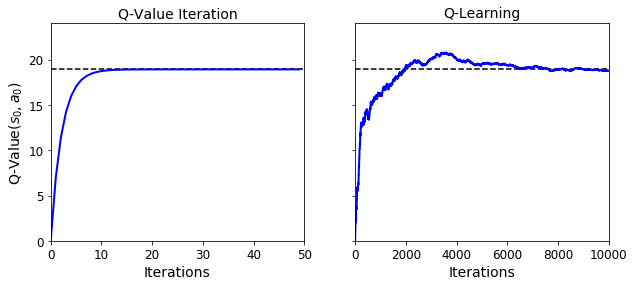

In [87]:
true_Q_value = history1[-1, 0, 0]

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
axes[0].set_ylabel("Q-Value$(s_0, a_0)$", fontsize=14)
axes[0].set_title("Q-Value Iteration", fontsize=14)
axes[1].set_title("Q-Learning", fontsize=14)
for ax, width, history in zip(axes, (50, 10000), (history1, history2)):
    ax.plot([0, width], [true_Q_value, true_Q_value], "k--")
    ax.plot(np.arange(width), history[:, 0, 0], "b-", linewidth=2)
    ax.set_xlabel("Iterations", fontsize=14)
    ax.axis([0, width, 0, 24])


# Deep Q-Network

Let's build a DQN which will estimate the sum of discounted future rewards after a chosen action, for each possible action and fiven state.

In [88]:

tf.random.set_seed(42)
np.random.seed(42)

env = gym.make("CartPole-v1")
input_shape = [4] # == env.observation_space.shape
n_outputs = 2 # == env.action_space.n

model = keras.models.Sequential([
    keras.layers.Dense(32, activation="elu", input_shape=input_shape),
    keras.layers.Dense(32, activation="elu"),
    keras.layers.Dense(n_outputs)
])

In [89]:
def epsilon_greedy_policy(state, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(2)
    else:
        Q_values = model.predict(state[np.newaxis])
        return np.argmax(Q_values[0])

In [90]:

from collections import deque

replay_memory = deque(maxlen=2000)


And let's create a function to sample experiences from the replay memory. It will return 5 NumPy arrays: [obs, actions, rewards, next_obs, dones].

In [91]:

def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_memory), size=batch_size)
    batch = [replay_memory[index] for index in indices]
    states, actions, rewards, next_states, dones = [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(5)]
    return states, actions, rewards, next_states, dones


Now we can create a function that will use the DQN to play one step, and record its experience in the replay memory:

In [92]:
def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, info = env.step(action)
    replay_memory.append((state, action, reward, next_state, done))
    return next_state, reward, done, info


Lastly, let's create a function that will sample some experiences from the replay memory and perform a training step:

In [94]:
batch_size = 32
discount_rate = 0.95
optimizer = keras.optimizers.Adam(lr=1e-3)
loss_fn = keras.losses.mean_squared_error

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    next_Q_values = model.predict(next_states)
    max_next_Q_values = np.max(next_Q_values, axis=1)
    target_Q_values = rewards + (1 - dones) * discount_rate * max_next_Q_values
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [95]:
env.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

rewards = [] 
best_score = 0

In [96]:
for episode in range(600):
    obs = env.reset()    
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        if done:
            break
    rewards.append(step) # Not shown in the book
    if step > best_score: # Not shown
        best_weights = model.get_weights() # Not shown
        best_score = step # Not shown
    print("\rEpisode: {}, Steps: {}, eps: {:.3f}".format(episode, step + 1, epsilon), end="") # Not shown
    if episode > 50:
        training_step(batch_size)

model.set_weights(best_weights)

Episode: 51, Steps: 11, eps: 0.898WARNING:tensorflow:Layer dense_4 is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Episode: 599, Steps: 91, eps: 0.0100

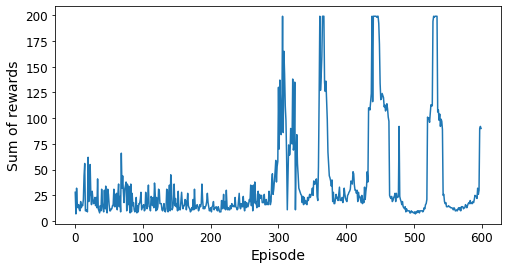

In [98]:
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.show()

In [99]:
env.seed(42)
state = env.reset()

frames = []

for step in range(200):
    action = epsilon_greedy_policy(state)
    state, reward, done, info = env.step(action)
    if done:
        break
    img = env.render(mode="rgb_array")
    frames.append(img)
    
plot_animation(frames)